# Model Selection
### by [Jason DeBacker](https://jasondebacker.com/), October 2021

This notebook illustrates how to perform model selection methods in Python.

*Model assessment* is the process of evaluating the performance of a particular model estimated on training data on its prediction accuracy on test data. There are many criteria for model assessment. The most common measure of model accuracy on test data is the mean squared error $MSE$ or root mean squared error $rMSE$. However, we have seen that the measure $MSE$ varies depending on which cross validation method is used.

*Model selection* is the process of selection the proper level of flexbility in a model. More flexibility provides a better fit of the model to the training data, but can result in worse performance on test data (i.e., overfitting). That is, they define model selection as a process of tuning a particular family or class of models to maximize accuracy on test set prediction. So model selection involves model assessment. However, one can expand this definition of model selection to include testing multiple families or classes of model in terms of accuracy--a horse race.

## 1. Set up

First, we import packages and modules we'll use. Then we read in and clean our data.

In [88]:
# Imports
import numpy as np
import pandas as pd
import os
from time import time
import sklearn
import sklearn.feature_selection
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RepeatedKFold

In [73]:
# Read in data and create variables
data_path = os.path.join('..', 'Optimization', 'PS4_data.dta')
psid = pd.read_stata(data_path)

# create wages and ln(wages)
# note need to be careful with wages = 0
psid['wage'] = psid['hlabinc']/psid['hannhrs']
psid['ln_wage'] = np.log(psid['wage'])

# create age squared
psid['age_sq'] = psid['age'] ** 2

# sample selection
psid.drop(psid[psid.hsex != 1].index, inplace=True)
psid.drop(psid[psid.age > 60].index, inplace=True)
psid.drop(psid[psid.age < 25].index, inplace=True)
psid.drop(psid[psid.wage < 7].index, inplace=True)
psid.drop(psid[psid.wage == np.inf].index, inplace=True)

# create dummy variables for race
psid['black'] = (psid['hrace'] == 2).astype(int)
psid['hispanic'] = (psid['hrace'] == 5).astype(int)
psid['other'] = (
    (psid['hrace'] == 3) | (psid['hrace'] == 4) |
    (psid['hrace'] == 6) | (psid['hrace'] == 7)).astype(int)

# drop obs if missing values for any variabls in regression model
psid.dropna(axis=0,
            subset=['ln_wage', 'hyrsed', 'age', 'age_sq', 'black', 'other'],
            inplace=True)

# add a constant
psid['const'] = 1

# keep just year 2000 so can compare to results from PS #4
psid = psid[psid.year==2000]

/Users/jason.debacker/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


## 2. Feature Selection

We'll now use forward and reverse step-wise selection methods to find the best fitting linear model of log wages.

In [100]:
# put our feature names in a list -- useful for labels later
feature_list = [
       'nochild', 'foodstamps', 'foodexp', 'foodcon',
       'redfinass', 'redtotass', 'redpregovinc',
       'hyrsed', 'age', 'age_sq', 'black', 'other'
    ]
# Need to put covariate names in an array for access later
feature_names = np.array(feature_list)
psid.dropna(axis=0,
            subset=feature_list,
            inplace=True)

# Separate covariates and outcome variables
X = psid[feature_list]
y = psid['ln_wage']

# instantiate an estimator to use (could be lasso, ridge, here OLS)
regr = sklearn.linear_model.LinearRegression()

# Forward sequential selection
tic_fwd = time()
sfs_forward = sklearn.feature_selection.SequentialFeatureSelector(
    regr,  # model
    n_features_to_select=3,  # number of features in model
    direction='forward',
    n_jobs=1  # number of processes to parallelize over
    ).fit(X, y)
toc_fwd = time()

# Backward sequential selection
tic_bwd = time()
sfs_backward = sklearn.feature_selection.SequentialFeatureSelector(
    regr,  # model
    n_features_to_select=3,  # number of features in model
    direction='backward',
    n_jobs=1  # number of processes to parallelize over
    ).fit(X, y)
toc_bwd = time()
print("Features selected by forward sequential selection: "
      f"{feature_names[sfs_forward.get_support()]}")
print(f"Done in {toc_fwd - tic_fwd:.3f}s")
print("Features selected by backward sequential selection: "
      f"{feature_names[sfs_backward.get_support()]}")
print(f"Done in {toc_bwd - tic_bwd:.3f}s")

Features selected by forward sequential selection: ['redtotass' 'redpregovinc' 'hyrsed']
Done in 0.254s
Features selected by backward sequential selection: ['redtotass' 'redpregovinc' 'hyrsed']
Done in 0.515s


In [101]:
# Print MSE of the model
print('MSE of the forward selection = ', mean_squared_error(y, sfs_forward.predict(X)))

AttributeError: 'SequentialFeatureSelector' object has no attribute 'predict'

`scikit-learn` also allows for other methods of recursive stepwise selection that allow for some additional flexibility.  One of these is `RFECV`, which is "recursive feature elimination with cross-valiation" (not illustrated below, but you can pass this function custom objective functions to evaluate the importance of features in the model -- e.g., use an t-stat instread of changes in MSE to evaluate covariates to drop).

In [80]:
min_features_to_select = 1  # Minimum number of features to consider
regr = sklearn.linear_model.LinearRegression()  # Model to use
selector = sklearn.feature_selection.RFECV(
    regr,  # estimator to use
    step=1,  #number of features to remove at each step
    cv=5,  # use 5-fold cross validation
    min_features_to_select=min_features_to_select
)
selector = selector.fit(X, y)
selector.support_
# selector.ranking_

array([ True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True])

Optimal number of features : 11


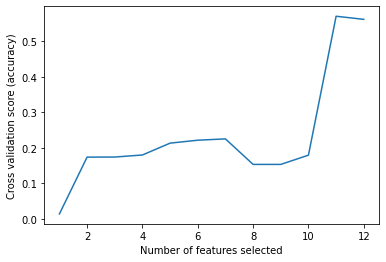

In [107]:
print("Optimal number of features : %d" % selector.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(range(min_features_to_select,
               len(selector.grid_scores_) + min_features_to_select),
         selector.grid_scores_)
plt.show()

In [89]:
mean_squared_error(y, selector.predict(X))

0.1510405691501279

## 3. MARS algorithm 

The [MARS algorithm](https://en.wikipedia.org/wiki/Multivariate_adaptive_regression_spline) finds the right basis functions and variables to include.

MARS is copyrighted, so open source software will call this same algorithm something different -- typically "Earth".  Here, we'll implement the MARS algorithm on our data using Python.  To do this, we'll need to install a new package, [`py-earth`](https://contrib.scikit-learn.org/py-earth/content.html#).  You can do this via:

```
pip install sklearn-contrib-py-earth
```

or

```
conda install -c conda-forge sklearn-contrib-py-earth
```

## NOTE: I've not been able to install from either source, so I will not show this in class.  It may work for you, though.


In [ ]:
# check pyearth version
import pyearth
# display version
print(pyearth.__version__)

In [ ]:
# define the model
model = Earth()

# fit the model on training dataset
model.fit(X, y)

# make a prediction
yhat = model.predict(Xnew)

In [ ]:
# print a summary of the fit model
print(model.summary())

In [ ]:
# Do some CV of the model...
# define the model
model = Earth()
# define the evaluation procedure
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate the model and collect results
n_scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# report performance
print('MAE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))